In [27]:
from os import chdir
chdir('/Users/lananhnguyen/Desktop/thesis/thesis_code')
import main.packages.mine_generic as mine_g
import main.packages.mine_specific as mine_s

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge


In [28]:
hicp_all_path = 'data/preprocessed/hicp_yoy.csv'
hicp_class_path = 'data/HICP_COICOP10s.xlsx'
model = 'ridge'
date_range = pd.date_range(start=mine_g.train_test_split_date + pd.DateOffset(months=1), end=mine_g.max_X_date, freq='M')

# 4.1. Ridge:
## Food:


In [29]:
category = 'Food'
cat_short = 'food'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'

save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)
food_cat_prediction = pd.DataFrame(index=date_range)

Number of items in Food group:  180


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


In [30]:
h = 1
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(2394, 2396, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)


N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_s.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
food_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast


Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 2394.5999999999995}
Horizon: 1
------------------------


In [31]:
h = 2
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(3040, 3042, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)


N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_g.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
food_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast


Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 3040.4999999999995}
Horizon: 2
------------------------


In [32]:
h = 3
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(3031, 3033, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)


Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 3031.5999999999995}


In [33]:


N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_s.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
food_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast


Horizon: 3
------------------------


In [34]:
food_yoy_real = pd.read_csv("data/preprocessed/food_yoy_infl.csv", parse_dates=True, index_col='date')
food_yoy_real_test = food_yoy_real[(food_yoy_real.index > mine_g.train_test_split_date) & (food_yoy_real.index <= mine_g.max_X_date)]
food_compare = pd.concat([food_cat_prediction, food_yoy_real_test], axis = 1)

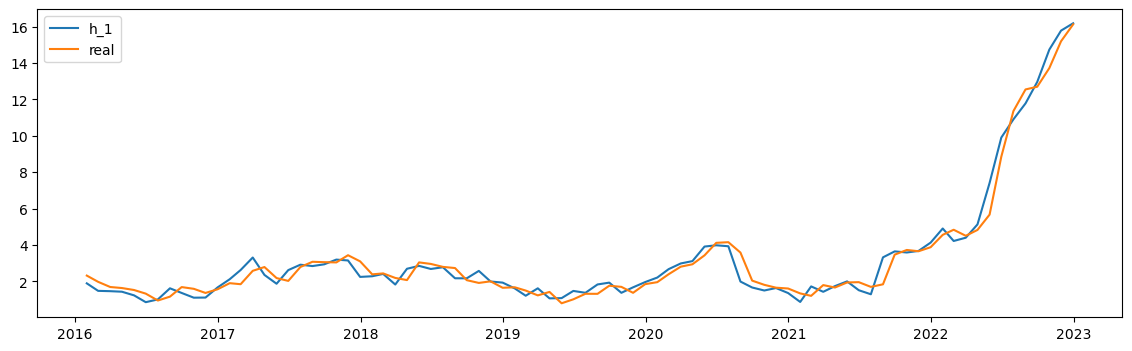

In [35]:
plt.figure(figsize=(14, 4))

plt.plot(food_compare.iloc[:, 0], label = "h_1")
plt.plot(food_compare.iloc[:, 1], label = "real")
plt.legend()
plt.show()

In [38]:
mine_g.save_forecast(forecast_result_df=food_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path, category=cat_short)

---

## Energy:


In [39]:
cat_short = 'energy'
category = 'Energy'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)

energy_cat_prediction = pd.DataFrame(index=date_range)

Number of items in Energy group:  14


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


In [40]:
h = 1
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(23, 24, 0.01),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)

N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_s.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
energy_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast


Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 23.730000000000114}
Horizon: 1
------------------------


In [41]:
h = 2
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(65, 70, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)


N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_s.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
energy_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast


Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 67.89999999999984}
Horizon: 2
------------------------


In [42]:
h = 3
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(105, 111, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)
N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_s.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
energy_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast

mine_g.save_forecast(forecast_result_df=energy_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path, category=cat_short)

Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 109.49999999999974}
Horizon: 3
------------------------


In [43]:
yoy_real = pd.read_csv(f"data/preprocessed/{cat_short}_yoy_infl.csv", parse_dates=True, index_col='date')
yoy_real_test = yoy_real[(yoy_real.index > mine_g.train_test_split_date) & (yoy_real.index <= mine_g.max_X_date)]
df_compare = pd.concat([energy_cat_prediction, yoy_real_test], axis = 1)

print(mean_absolute_error(df_compare.loc[:, 'yoy_rate'], df_compare.loc[:, f'ridge_{cat_short}_h_1']))
print(np.sqrt(mean_squared_error(df_compare.loc[:, 'yoy_rate'], df_compare.loc[:, f'ridge_{cat_short}_h_1'])))

2.498768734307513
3.835046628231574


## NEIG:

In [44]:
cat_short = 'neig'
category = 'Non-energy industrial goods (NEIG)'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)
neig_cat_prediction = pd.DataFrame(index=date_range)

Number of items in Non-energy industrial goods (NEIG) group:  302


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


In [45]:
h = 1
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(2280, 2282, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)

Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 2281.4999999999986}


In [46]:
N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_s.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
neig_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast


Horizon: 1
------------------------


In [47]:
h = 2
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(2150, 2153, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)

Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 2151.299999999999}


In [48]:
N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_s.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
neig_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast

Horizon: 2
------------------------


In [49]:
h = 3
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(2475, 2480, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)

Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 2476.099999999999}


In [50]:
N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_s.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
neig_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast

# save forecast:
mine_g.save_forecast(forecast_result_df=neig_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path, category=cat_short)

Horizon: 3
------------------------


In [51]:
yoy_real = pd.read_csv(f"data/preprocessed/{cat_short}_yoy_infl.csv", parse_dates=True, index_col='date')
yoy_real_test = yoy_real[(yoy_real.index > mine_g.train_test_split_date) & (yoy_real.index <= mine_g.max_X_date)]
df_compare = pd.concat([neig_cat_prediction, yoy_real_test], axis = 1)

print(mean_absolute_error(df_compare.loc[:, 'yoy_rate'], df_compare.loc[:, f'ridge_{cat_short}_h_1']))
print(np.sqrt(mean_squared_error(df_compare.loc[:, 'yoy_rate'], df_compare.loc[:, f'ridge_{cat_short}_h_1'])))

0.3798863764303298
0.58229480794593


## Services:

In [52]:
cat_short = 'services'
category = 'Services'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)
services_cat_prediction = pd.DataFrame(index=date_range)

Number of items in Services group:  148


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


In [53]:
h = 1
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(435, 440, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)

Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 438.2000000000007}


In [54]:
N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_s.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
services_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast

Horizon: 1
------------------------


In [55]:
h = 2
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(300, 302, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)

Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 301.0000000000002}


In [56]:
N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_s.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
services_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast

Horizon: 2
------------------------


In [57]:
h = 3
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(290, 300, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)

Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 291.4000000000003}


In [58]:
N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_s.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
services_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast


# save forecast:
mine_g.save_forecast(forecast_result_df=services_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path, category=cat_short)

Horizon: 3
------------------------


In [59]:
yoy_real = pd.read_csv(f"data/preprocessed/{cat_short}_yoy_infl.csv", parse_dates=True, index_col='date')
yoy_real_test = yoy_real[(yoy_real.index > mine_g.train_test_split_date) & (yoy_real.index <= mine_g.max_X_date)]
df_compare = pd.concat([services_cat_prediction, yoy_real_test], axis = 1)

print(mean_absolute_error(df_compare.loc[:, 'yoy_rate'], df_compare.loc[:, f'ridge_{cat_short}_h_1']))
print(np.sqrt(mean_squared_error(df_compare.loc[:, 'yoy_rate'], df_compare.loc[:, f'ridge_{cat_short}_h_1'])))

0.552605982496602
0.7054945929931593
